In [3]:

from nibabel.testing import data_path
import brainspace
import pandas as pd
import numpy as np
import os
import nibabel as nib
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [16]:
# Margulies et al (2016) gradient as reference for alignment
grads = ["1", "2", "3"]
directory = "HCP/Gradients_Margulies2016/fsLR/"
sessions_4k = []
wb_margulies_4kgradients = []
for grad in grads:
    path_L = directory + "hcp.embed.grad_%s.L.4k.fslr.func.gii" % (grad)
    path_R = directory + "hcp.embed.grad_%s.R.4k.fslr.func.gii" % (grad)
    gradient_L = nib.load(path_L).agg_data()
    gradient_R = nib.load(path_R).agg_data()
    gradient = np.concatenate((gradient_L, gradient_R))
    wb_margulies_4kgradients.append(gradient)
wb_margulies_4kgradients = np.stack((wb_margulies_4kgradients))

In [17]:
wb_margulies_4kgradients.shape

(3, 8004)

In [22]:
grads = ["1", "2", "3"] # our subject gradients
directory = "HCP/resampled_grads/"
sessions_4k = []
subjects = np.loadtxt("HCP/subj.txt", dtype = "str")
for session_n in ["1", "2"]:
    subjects_grads_4k = []
    for subject_id in subjects:
        gradients = []
        for grad in grads:
            path_L = directory + "%s_grad%s_ses%s_L4k.func.gii" % (subject_id, grad, session_n)
            path_R = directory + "%s_grad%s_ses%s_R4k.func.gii" % (subject_id, grad, session_n)
            gradient_L = nib.load(path_L).agg_data()
            gradient_R = nib.load(path_R).agg_data()
            grad = np.concatenate((gradient_L, gradient_R))
            gradients.append(grad)
            #print("gradient: ", grad)
        gradients = np.stack((gradients))
        #print("gradients: ", gradients)
        subjects_grads_4k.append(gradients)
    subjects_grads_4k = np.stack((subjects_grads_4k))
    #print("subjects_grads_4k: ", subjects_grads_4k)
    sessions_4k.append(subjects_grads_4k)
sessions_4k = np.stack((sessions_4k))

In [23]:
sessions_4k = sessions_4k.reshape(10, 3, 8004)
gradients4k_all_sessions = [subject_grads[:, ~(subject_grads == 0).all(axis=0)] for subject_grads in sessions_4k]


In [25]:
from brainspace.gradient.alignment import ProcrustesAlignment

alignment = ProcrustesAlignment()
gradients4k_all_sessions_aligned = alignment.fit(sessions_4k, wb_margulies_4kgradients) #aligningm first subject, 1st sessions as reference

In [27]:
gradients4k_all_sessions_aligned.aligned_

[array([[ 6.0272617e+00, -4.8041368e+00, -2.9159086e+00, ...,
          5.5554767e+00,  5.9817209e+00,  5.7131748e+00],
        [-8.2188398e-03, -2.2899742e+00, -1.7640035e+00, ...,
          1.2738188e-01,  5.4928839e-02,  1.3850984e-01],
        [-1.3953506e+00, -8.0613208e-01, -1.1973484e+00, ...,
          3.4290516e-01, -3.1649071e-01,  2.6671488e-03]], dtype=float32),
 array([[ 6.074743  , -4.8435125 , -2.938327  , ...,  5.5927067 ,
          6.024446  ,  5.753022  ],
        [ 0.03496942, -2.5897014 , -1.9844368 , ...,  0.16474201,
          0.09299406,  0.18203439],
        [-1.7499454 , -0.95625913, -1.4526815 , ...,  0.40072474,
         -0.4159083 , -0.0208547 ]], dtype=float32),
 array([[ 3.510816  , -2.8137043 , -1.7121284 , ...,  3.243929  ,
          3.4894114 ,  3.3344126 ],
        [ 0.01431121, -1.4366521 , -1.1036637 , ...,  0.09508337,
          0.05210555,  0.10288242],
        [-1.0285282 , -0.62144667, -0.9095943 , ...,  0.27753824,
         -0.21701509,  0.02209

In [95]:
np.save(file = "aligned_gradients.npy", arr = np.asarray(gradients4k_all_sessions_aligned.aligned_))

In [96]:
all_gradients4k_all_sessions_aligned = np.load("aligned_gradients.npy")
#all_gradients4k_all_sessions_aligned = np.insert(arr = all_gradients4k_all_sessions_aligned, obj = 0, values = np.expand_dims(gradients4k_all_sessions[0], axis = 0), axis = 0)

In [38]:
labs_L_4k_metric = nib.load('HCP/labels/fsLR.4k.L.label_metric.gii').agg_data() # loading labels resampled with 2 diff. techniques
labs_R_4k_metric = nib.load('HCP/labels/fsLR.4k.R.label_metric.gii').agg_data()
labs_4k_metric  = np.concatenate((labs_L_4k_metric, labs_R_4k_metric))

labs_L_4k = nib.load('HCP/labels/fsLR.4k.L.label.gii').agg_data()
labs_R_4k = nib.load('HCP/labels/fsLR.4k.R.label.gii').agg_data()
labs_4k  = np.concatenate((labs_L_4k, labs_R_4k)) # the right labels


In [122]:
labs_4k_metric = labs_4k_metric.astype(float)
labs_4k_metric[labs_4k_metric == 0] = np.nan
cortical_indices_4k_metric = np.where(np.isnan(labs_4k_metric) == False)[0]

labs_4k = labs_4k.astype(float)
labs_4k[labs_4k == 0] = np.nan
medial_wall_mask = np.where(np.isnan(labs_4k) == True)[0] # medial wall mask from the right labels

labs_margulies_4k = labs_4k
labs_margulies_4k[np.where(wb_margulies_4kgradients[0] == 0)] = 0
medial_wall_margulies = np.where(wb_margulies_4kgradients[0] == 0)[0]


In [49]:
grads_ses1_4k_aligned = all_gradients4k_all_sessions_aligned[:int(len(all_gradients4k_all_sessions_aligned)/2)] # shape (subj, grad, vertices)
grads_ses2_4k_aligned = all_gradients4k_all_sessions_aligned[int(len(all_gradients4k_all_sessions_aligned)/2):]

labeled_grads_ses1_4k_aligned = np.empty((5, 3, 8004))
labeled_grads_ses1_4k_aligned[:] = np.nan

labeled_grads_ses2_4k_aligned = np.empty((5, 3, 8004))
labeled_grads_ses2_4k_aligned[:] = np.nan

for subject, subject_map in zip(grads_ses1_4k_aligned, labeled_grads_ses1_4k_aligned):
    subject_map[0][cortical_indices_4k_metric] = subject[0]
    subject_map[0][medial_wall_margulies] = np.nan
    subject_map[1][cortical_indices_4k_metric] = subject[1]
    subject_map[1][medial_wall_margulies] = np.nan
    subject_map[2][cortical_indices_4k_metric] = subject[2]
    subject_map[2][medial_wall_margulies] = np.nan

for subject, subject_map in zip(grads_ses2_4k_aligned, labeled_grads_ses2_4k_aligned):
    subject_map[0][cortical_indices_4k_metric] = subject[0]
    subject_map[0][medial_wall_margulies] = np.nan
    subject_map[1][cortical_indices_4k_metric] = subject[1]
    subject_map[1][medial_wall_margulies] = np.nan
    subject_map[2][cortical_indices_4k_metric] = subject[2]
    subject_map[2][medial_wall_margulies] = np.nan

ValueError: shape mismatch: value array of shape (8004,) could not be broadcast to indexing result of shape (7344,)

In [137]:
grads_ses1_4k_aligned = all_gradients4k_all_sessions_aligned[:int(len(all_gradients4k_all_sessions_aligned)/2)] # shape (subj, grad, vertices)
grads_ses2_4k_aligned = all_gradients4k_all_sessions_aligned[int(len(all_gradients4k_all_sessions_aligned)/2):]

labeled_grads_ses1_4k_aligned = np.empty((5, 3, 8004))
labeled_grads_ses1_4k_aligned[:] = np.nan

labeled_grads_ses2_4k_aligned = np.empty((5, 3, 8004))
labeled_grads_ses2_4k_aligned[:] = np.nan
for i in range(len(grads_ses1_4k_aligned)):
    labeled_grads_ses1_4k_aligned[i] = grads_ses1_4k_aligned[i]
    for gradient in labeled_grads_ses1_4k_aligned[i]:
        gradient[medial_wall_margulies] = np.nan

labeled_grads_ses2_4k_aligned = np.empty((5, 3, 8004))
labeled_grads_ses2_4k_aligned[:] = np.nan
for i in range(len(grads_ses2_4k_aligned)):
    labeled_grads_ses2_4k_aligned[i] = grads_ses2_4k_aligned[i]
    for gradient in labeled_grads_ses2_4k_aligned[i]:
        gradient[medial_wall_margulies] = np.nan


Text(0.5, 1.0, 'Procrustes aligned: S1, ses 1, Grad 2')

Text(0.5, 1.0, 'Procrustes aligned: S1, ses 1, Grad 2')

Text(0.5, 1.0, 'Procrustes aligned: S2, ses 1, Grad 2')

Text(0.5, 1.0, 'Procrustes aligned: S2, ses 1, Grad 2')

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_15420/1709566229.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  grad2_s1_ses1.show()
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_15420/1709566229.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  grad2_s1_ses2.show()
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_15420/1709566229.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  grad2_s2_ses1.show()
/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_15420/1709566229.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  grad2_s2_ses2.show()


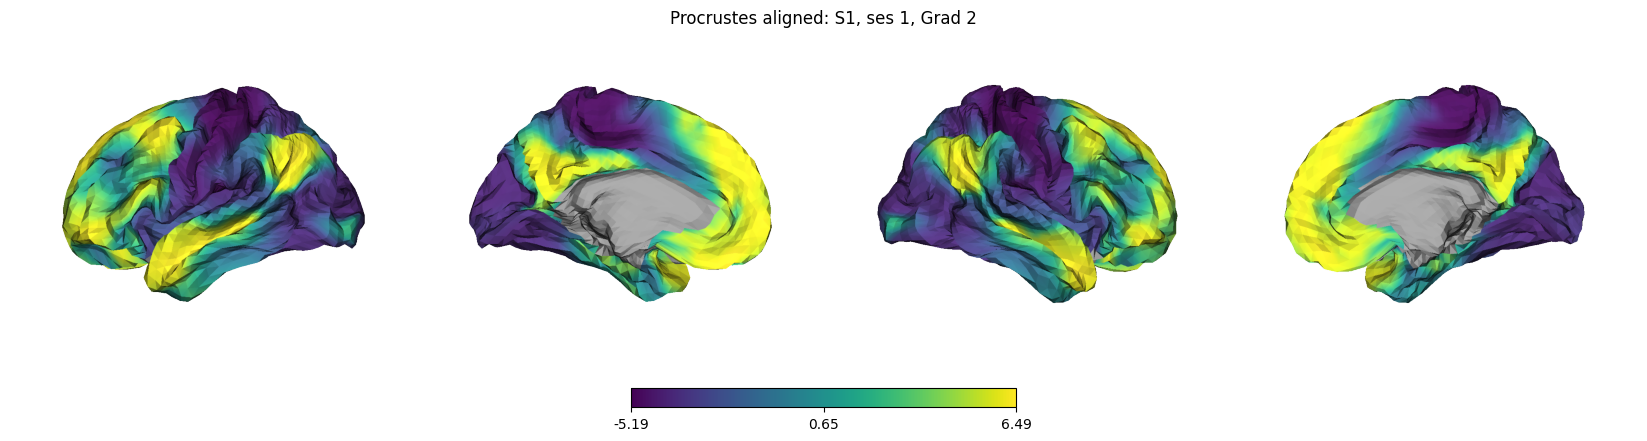

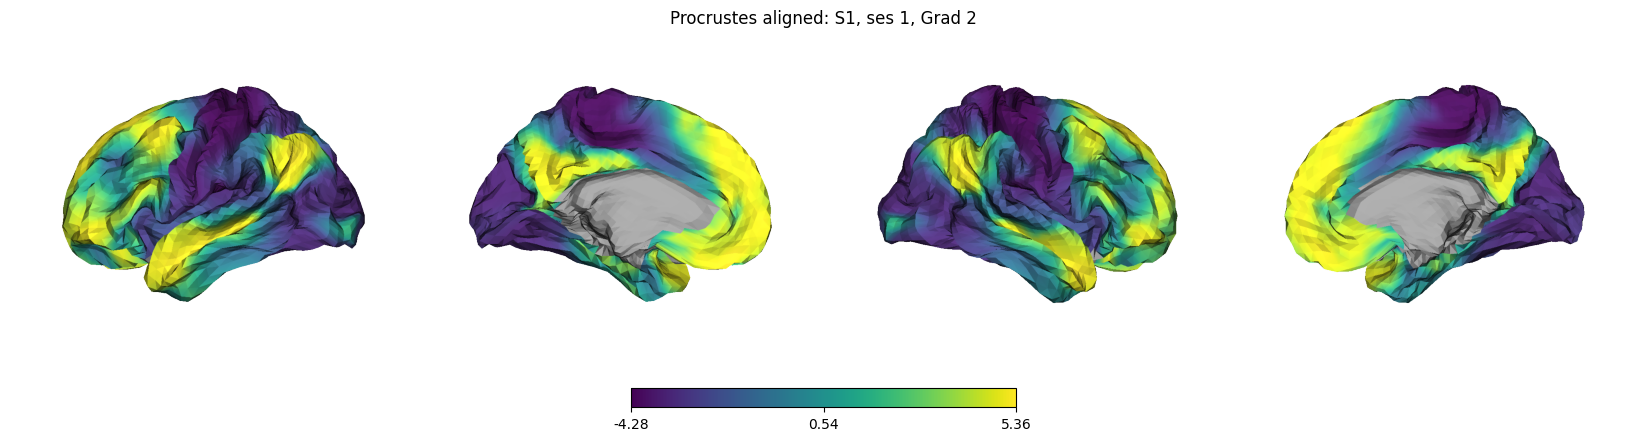

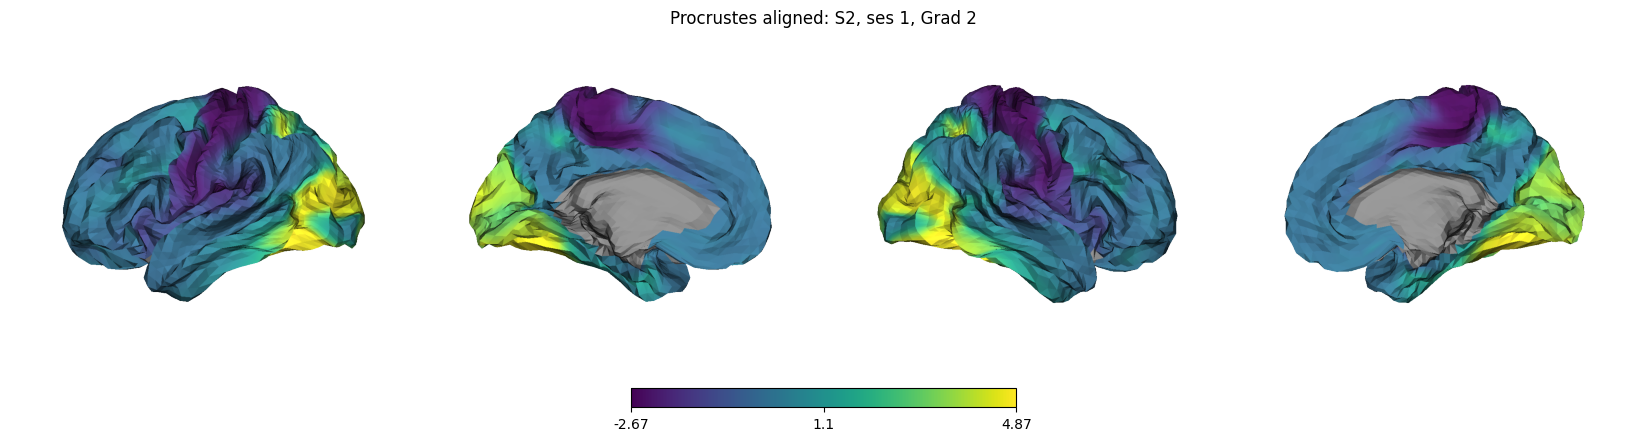

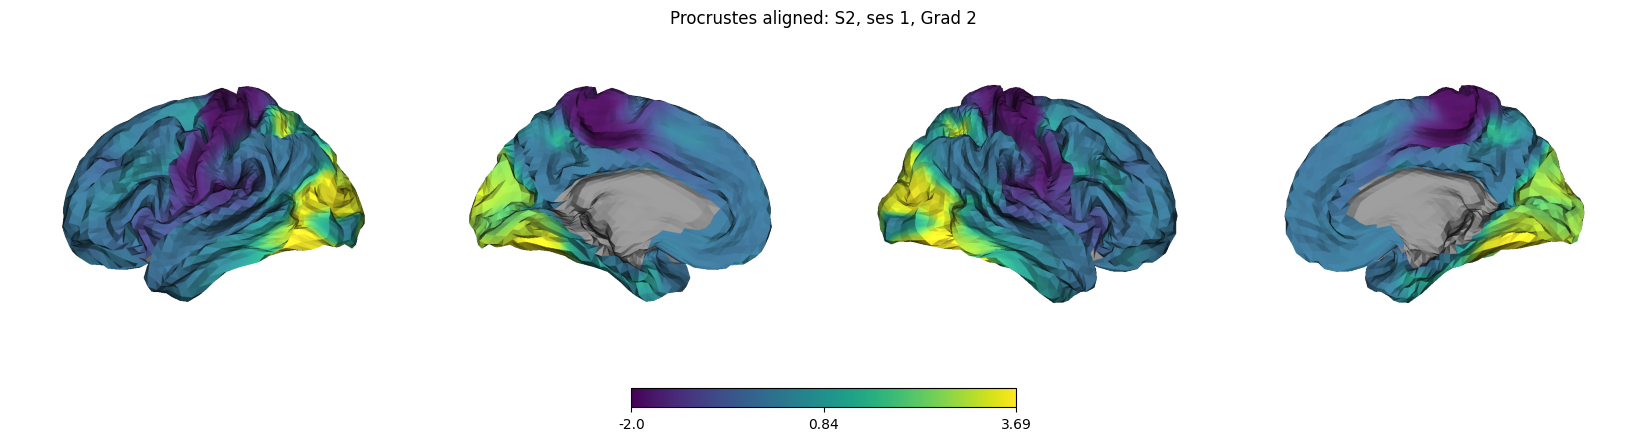

In [138]:
#plot the second gradient from 2 subjects, both sessions
from surfplot.plotting import Plot

grad2_s1_ses1 = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False) 
grad2_s1_ses2 = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False)
grad2_s2_ses1 = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False)
grad2_s2_ses2 = Plot("HCP/surfaces/fslr_L_mid_4k.gii", "HCP/surfaces/fslr_R_mid_4k.gii", layout='row', zoom=1.2, size=(2000,400), mirror_views=False)

grad2_s1_ses1.add_layer(labeled_grads_ses1_4k_aligned[0][0], cmap='viridis')
grad2_s1_ses2.add_layer(labeled_grads_ses2_4k_aligned[0][0], cmap='viridis')

grad2_s2_ses1.add_layer(labeled_grads_ses1_4k_aligned[0][1], cmap='viridis')
grad2_s2_ses2.add_layer(labeled_grads_ses2_4k_aligned[0][1], cmap='viridis')


grad2_s1_ses1 = grad2_s1_ses1.build()
grad2_s1_ses1.axes[0].set_title("Procrustes aligned: S1, ses 1, Grad 2")

grad2_s1_ses2 = grad2_s1_ses2.build()
grad2_s1_ses2.axes[0].set_title("Procrustes aligned: S1, ses 1, Grad 2")

grad2_s2_ses1 = grad2_s2_ses1.build()
grad2_s2_ses1.axes[0].set_title("Procrustes aligned: S2, ses 1, Grad 2")

grad2_s2_ses2 = grad2_s2_ses2.build()
grad2_s2_ses2.axes[0].set_title("Procrustes aligned: S2, ses 1, Grad 2")

grad2_s1_ses1.show()
grad2_s1_ses2.show()
grad2_s2_ses1.show()
grad2_s2_ses2.show()

Text(0.5, 0, 'Gradient 2')

Text(0.5, 0.5, 'Gradient 1')

Text(0.5, 0, 'Gradient 3')

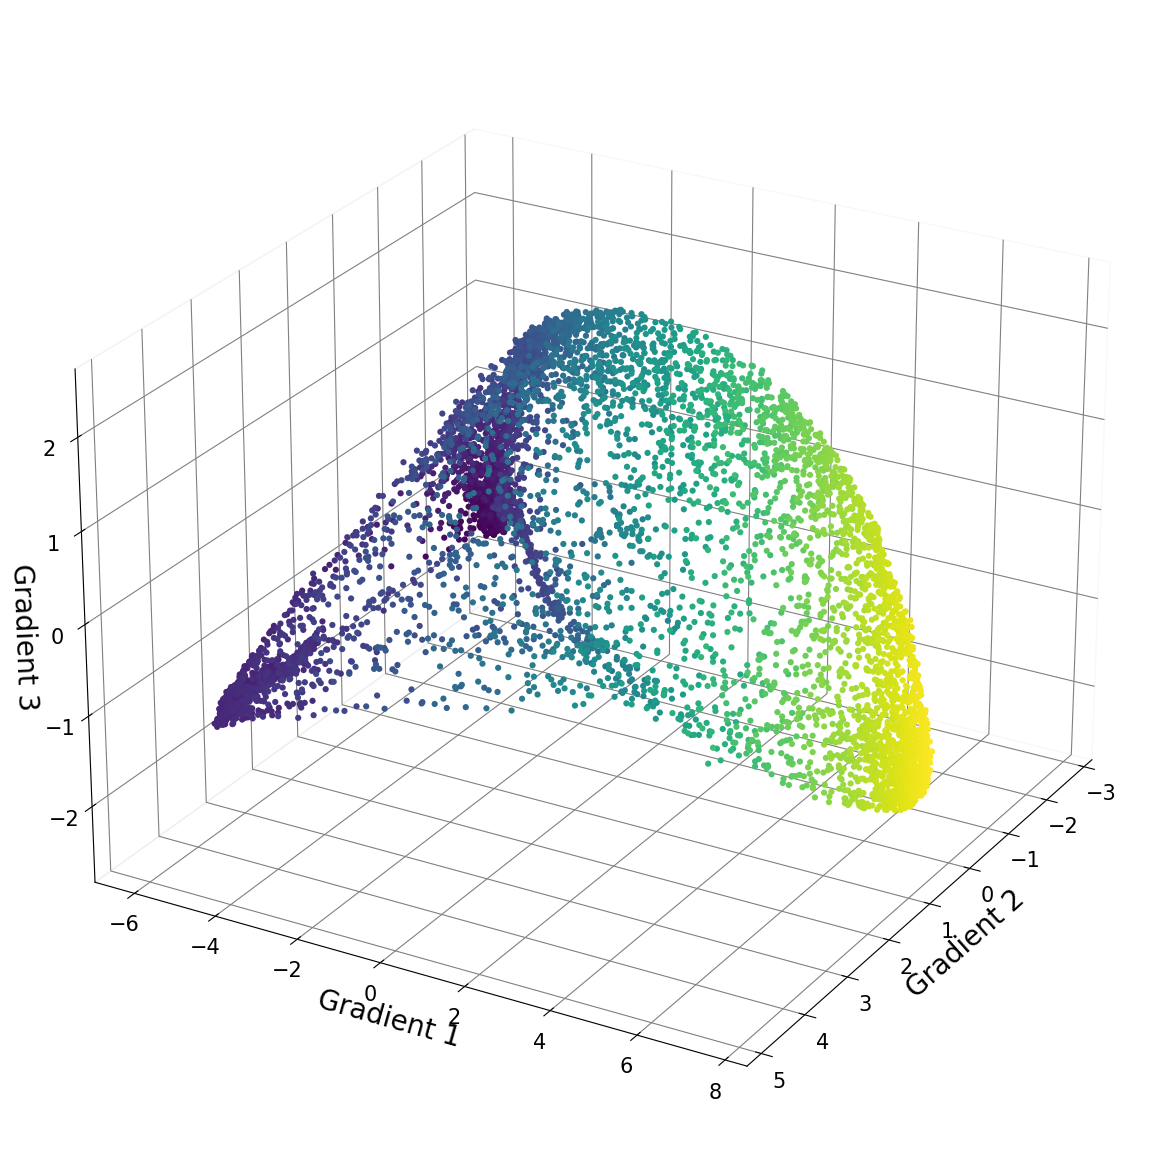

In [139]:
# verifying that gradients are aligned (same shape of the gradient embedding)
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

fig = plt.figure(figsize = ((15, 15)))
ax = fig.add_subplot(projection='3d')

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis.line.set_color("black")
ax.yaxis.line.set_color("black")
ax.zaxis.line.set_color("black")

ax.xaxis._axinfo["grid"]['color'] =  ("grey")
ax.yaxis._axinfo["grid"]['color'] =  ("grey")
ax.zaxis._axinfo["grid"]['color'] =  ("grey")

#cmap = ListedColormap(sns.color_palette("viridis", 256).as_hex())

ax.scatter(grads_ses1_4k_aligned[3][1], grads_ses1_4k_aligned[3][0], grads_ses1_4k_aligned[3][2], cmap='viridis', linewidth = 0.000000001, c = grads_ses1_4k_aligned[3][0], alpha =1)

# Get rid of the panes                          

ax.set_xlabel('Gradient 2', fontsize = 20)
ax.set_ylabel('Gradient 1', fontsize = 20)
ax.set_zlabel('Gradient 3',fontsize = 20)

ax.tick_params(which='major', labelsize=15)

ax.view_init(25, 30)

# legend
#plt.legend(*gradient_3d.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

Text(0.5, 0, 'Gradient 2')

Text(0.5, 0.5, 'Gradient 1')

Text(0.5, 0, 'Gradient 3')

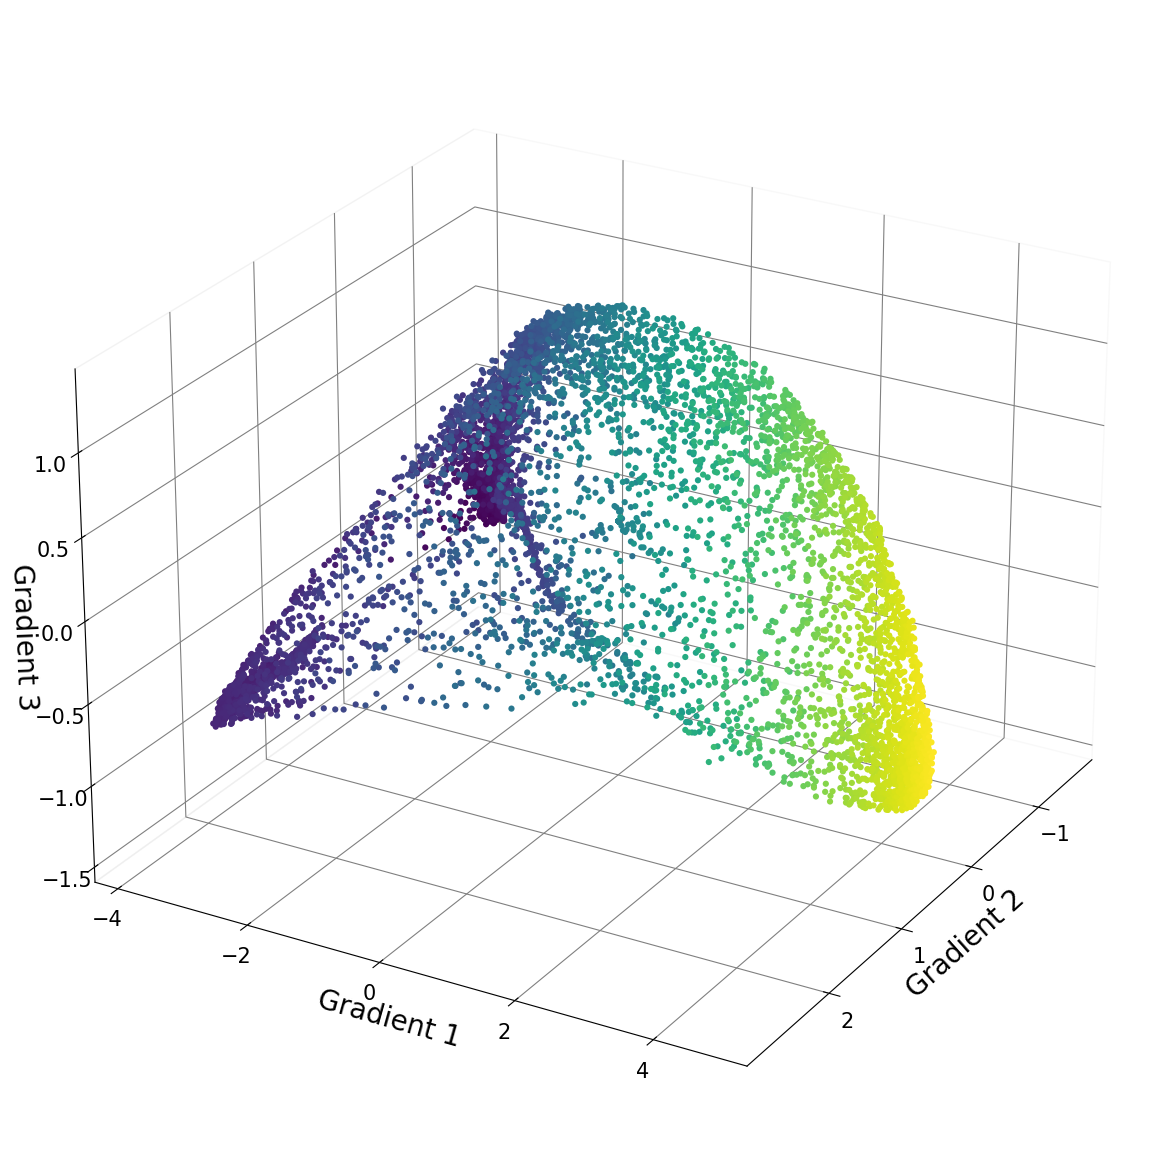

In [140]:
fig = plt.figure(figsize = ((15, 15)))
ax = fig.add_subplot(projection='3d')

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis.line.set_color("black")
ax.yaxis.line.set_color("black")
ax.zaxis.line.set_color("black")

ax.xaxis._axinfo["grid"]['color'] =  ("grey")
ax.yaxis._axinfo["grid"]['color'] =  ("grey")
ax.zaxis._axinfo["grid"]['color'] =  ("grey")

#cmap = ListedColormap(sns.color_palette("viridis", 256).as_hex())

ax.scatter(grads_ses2_4k_aligned[2][1], grads_ses2_4k_aligned[2][0], grads_ses2_4k_aligned[2][2], cmap='viridis', linewidth = 0.000000001, c = grads_ses2_4k_aligned[2][0], alpha =1)

# Get rid of the panes                          

ax.set_xlabel('Gradient 2', fontsize = 20)
ax.set_ylabel('Gradient 1', fontsize = 20)
ax.set_zlabel('Gradient 3',fontsize = 20)

ax.tick_params(which='major', labelsize=15)

ax.view_init(25, 30)

# legend
#plt.legend(*gradient_3d.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

In [141]:
np.save(arr = grads_ses1_4k_aligned, file = "grads_ses1_4k_aligned.npy")
np.save(arr = grads_ses2_4k_aligned, file = "grads_ses2_4k_aligned.npy")

np.save(arr = labeled_grads_ses1_4k_aligned, file = "labeled_grads_ses1_4k_aligned.npy")
np.save(arr = labeled_grads_ses2_4k_aligned, file = "labeled_grads_ses2_4k_aligned.npy")